# Marly Integration with Autogen
This notebook example shows how Marly can be used together with Autogen to perform tasks. In the below example workflow, two Agents: pdf_processor and code_executor convert table data from a 10k pdf report into a line chart. Users only need to instruct the agents what table schemas need to be extracted from which pdf file. 

The pdf_generator is using Marly as a tool to perform high quality data extraction based on pdf document and schema.

### Install Dependencies

In [1]:
%%capture --no-stderr
%pip install "pyautogen>=0.2.3" pandas matplotlib PyPDF2
%pip install marly
%pip install groq

### Define Tools

In [8]:
# Function calls using Marly for extracting schema data from pdf
import marly
from marly import Marly
import logging
import base64
import zlib
import os
import json
from dotenv import load_dotenv
import time
load_dotenv()

client = Marly(
    base_url="http://localhost:8100",
)

PDF_FILE_PATH = "./lacers_reduced.pdf"

# Define schema for Marly, table column name and a breif description of the column
SCHEMA = json.dumps({
        "Firm": "The name of the firm",
        "Number of Funds": "The number of funds managed by the firm",
        "Commitment": "The commitment amount in millions of dollars",
        "Percent of Total Comm": "The percentage of total commitment",
        "Exposure (FMV + Unfunded)": "The exposure including fair market value and unfunded commitments in millions of dollars",
        "Percent of Total Exposure": "The percentage of total exposure",
        "TVPI": "Total Value to Paid-In multiple",
        "Net IRR": "Net Internal Rate of Return as a percentage"
    })

def read_and_encode_pdf(file_path):
    with open(file_path, "rb") as file:
        pdf_content = base64.b64encode(zlib.compress(file.read())).decode('utf-8')
    logging.debug(f"{file_path} read and encoded")
    return pdf_content

def to_dict(results):
    return {"results": [result.to_dict() for result in results]}

def process_pdf_tool(pdf_file_path: str, schema: str) -> list[dict]:
    """Use this to process the pdf file. """
    pipeline_response_model = None
    try:
        pipeline_response_model = client.pipelines.create(
            api_key=os.environ.get("GROQ_API_KEY"),
            provider_model_name="llama-3.1-70b-versatile",
            provider_type="groq",
            workloads=[
                {
                    "pdf_stream": read_and_encode_pdf(pdf_file_path),
                    "schemas": [schema]
                }
            ]
        )
    except marly.APIConnectionError as e:
        print("The server could not be reached")
        print(e.__cause__)
    except marly.RateLimitError as e:
        print("A 429 status code was received; we should back off a bit.")
    except marly.APIStatusError as e:
        print("Another non-200-range status code was received")
        print(e.status_code)
        print(e.response)

    max_attempts = 100
    attempt = 0
    while attempt < max_attempts:
        logging.debug(f"Waiting for pipeline to complete. Attempt {attempt + 1} of {max_attempts}")
        time.sleep(1)

        results = client.pipelines.retrieve(pipeline_response_model.task_id)
        logging.debug(f"Poll attempt {attempt + 1}: Status - {results.status}")

        if results.status == 'COMPLETED':
            logging.debug(f"Pipeline completed with results: {results.results}")
            return to_dict(results.results)
        elif results.status == 'FAILED':
            logging.error(f"Error: {results.get('error_message', 'Unknown error')}")
            return None

        attempt += 1

    logging.warning("Timeout: Pipeline execution took too long.")
    return None


In [10]:
# Here we're using langchain PythonREPL tool to execute any arbitrary Python code, if you dont have Langchain library installed, uncomment below line to install
# %pip install langchain, langchain_experimental

# Function to execute any Python function. Note: USE WITH CAUTION
from langchain_experimental.utilities import PythonREPL
repl = PythonREPL()

# Define the tool to execute python code
def python_repl(
    code: str,
):
    """Use this to execute python code. """
    try:
        print(f"code to execute: {code}")
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### Define Agents

In [12]:
import autogen
from autogen.coding import LocalCommandLineCodeExecutor

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
)

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}

# Agent that can call process_pdf_tool function to process pdf
pdf_processor = autogen.AssistantAgent(
    name="pdf_processor",
    llm_config=llm_config,
    system_message='''You are an expert at extracting data for a schema from PDFs.
     For pdf processing tasks, only use the functions you have been provided with.
     Reply TERMINATE when the task is done and there's no problem''',
)

# Agent that can call python_repl function to write and execute python code
code_executor = autogen.AssistantAgent(
    name="code_executor",
    llm_config=llm_config,
    system_message='''You are an expert at writing python code and execute the code.
      For code execution tasks, only use the functions you have been provided with.
      Reply TERMINATE when the task is solved and there is no problem.''',
)


# executor = LocalCommandLineCodeExecutor(work_dir="coding")

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=100,
    # code_execution_config={
    #     "executor": executor,
    # }
)


### Assign Tools to the Agents

In [13]:
from typing_extensions import Annotated

# Assign process_pdf_tool function call to pdf_processor
@user_proxy.register_for_execution()
@pdf_processor.register_for_llm(description="pdf_processor")
def process_pdf(pdf_file_path: Annotated[str, "PDF to be processed"], schema: Annotated[str, "Schema for the data to be extracted"]) -> list[dict]:
    return process_pdf_tool(pdf_file_path, schema)

# Assign python_repl function call to code_executor
@user_proxy.register_for_execution()
@code_executor.register_for_llm(description="code_executor")
def execute_function(code: Annotated[str, "Python code to be executed"]) -> str:
    python_repl(code)
    return "Done"

### Execute the flow

user_proxy (to pdf_processor):

What data can you extract from the pdf under path ./lacers_reduced.pdf with the given schema {"Firm": "The name of the firm", "Number of Funds": "The number of funds managed by the firm", "Commitment": "The commitment amount in millions of dollars", "Percent of Total Comm": "The percentage of total commitment", "Exposure (FMV + Unfunded)": "The exposure including fair market value and unfunded commitments in millions of dollars", "Percent of Total Exposure": "The percentage of total exposure", "TVPI": "Total Value to Paid-In multiple", "Net IRR": "Net Internal Rate of Return as a percentage"}

--------------------------------------------------------------------------------
pdf_processor (to user_proxy):

***** Suggested tool call (call_9dwy): process_pdf *****
Arguments: 
{"pdf_file_path": "./lacers_reduced.pdf", "schema": "{\"Firm\": \"The name of the firm\", \"Number of Funds\": \"The number of funds managed by the firm\", \"Commitment\": \"The commitm

/opt/homebrew/lib/python3.12/site-packages/autogen/oai/groq.py:286: UserWarning: Cost calculation not available for model llama-3.1-70b-versatile
  warnings.warn(f"Cost calculation not available for model {model}", UserWarning)


user_proxy (to pdf_processor):

user_proxy (to pdf_processor):

***** Response from calling tool (call_9dwy) *****
{"results": [{"metrics": {"schema_0": "{\n   \"Firm\": [\n      \"Vista Equity Partners\",\n      \"ABRY Partners\",\n      \"Advent International\",\n      \"Thoma Bravo\",\n      \"Platinum Equity\",\n      \"Spark Management Partners\",\n      \"New Enterprise Associates\",\n      \"Technology Crossover Ventures\",\n      \"EnCap Investments\",\n      \"Hellman & Friedman\"\n   ],\n   \"Number of Funds\": [\n      \"7\",\n      \"6\",\n      \"5\",\n      \"5\",\n      \"4\",\n      \"6\",\n      \"4\",\n      \"5\",\n      \"4\",\n      \"5\"\n   ],\n   \"Commitment\": [\n      \"185,000,000\",\n      \"145,000,000\",\n      \"145,000,000\",\n      \"90,000,000\",\n      \"112,500,000\",\n      \"93,750,000\",\n      \"95,000,000\",\n      \"104,500,000\",\n      \"120,000,000\",\n      \"100,463,972\"\n   ],\n   \"Percent of Total Comm\": [\n      \"3.6\",\n      \"2.

code to execute: import pandas as pd
import matplotlib.pyplot as plt

# Define the data
firms = ['Vista Equity Partners', 'ABRY Partners', 'Advent International', 'Thoma Bravo', 'Platinum Equity', 'Spark Management Partners', 'New Enterprise Associates', 'Technology Crossover Ventures', 'EnCap Investments', 'Hellman & Friedman']
commitments = [185000000, 145000000, 145000000, 90000000, 112500000, 93750000, 95000000, 104500000, 120000000, 100463972]

# Create a pandas DataFrame
chart_data = pd.DataFrame({
    'Firm': firms,
    'Commitment': commitments
})

# Plot the chart
plt.figure(figsize=(10, 5))
plt.bar('Firm', 'Commitment', data=chart_data)
plt.xlabel('Firm Name')
plt.ylabel('Commitment ($ millions)')
plt.title('Commitments by Firm')
plt.xticks(rotation=90)
plt.tight_layout()

# Save the plot to an image file
plt.savefig('plot.png')
print('Plot saved to plot.png')

user_proxy (to code_executor):

user_proxy (to code_executor):

***** Response from calling tool (call_tpy5) *****
D

/opt/homebrew/lib/python3.12/site-packages/autogen/oai/groq.py:286: UserWarning: Cost calculation not available for model llama-3.1-70b-versatile
  warnings.warn(f"Cost calculation not available for model {model}", UserWarning)


ChatResult(chat_id=None, chat_history=[{'content': 'Write Python code to plot a chart of the firm and their commitments based on {"results": [{"metrics": {"schema_0": "{\\n   \\"Firm\\": [\\n      \\"Vista Equity Partners\\",\\n      \\"ABRY Partners\\",\\n      \\"Advent International\\",\\n      \\"Thoma Bravo\\",\\n      \\"Platinum Equity\\",\\n      \\"Spark Management Partners\\",\\n      \\"New Enterprise Associates\\",\\n      \\"Technology Crossover Ventures\\",\\n      \\"EnCap Investments\\",\\n      \\"Hellman & Friedman\\"\\n   ],\\n   \\"Number of Funds\\": [\\n      \\"7\\",\\n      \\"6\\",\\n      \\"5\\",\\n      \\"5\\",\\n      \\"4\\",\\n      \\"6\\",\\n      \\"4\\",\\n      \\"5\\",\\n      \\"4\\",\\n      \\"5\\"\\n   ],\\n   \\"Commitment\\": [\\n      \\"185,000,000\\",\\n      \\"145,000,000\\",\\n      \\"145,000,000\\",\\n      \\"90,000,000\\",\\n      \\"112,500,000\\",\\n      \\"93,750,000\\",\\n      \\"95,000,000\\",\\n      \\"104,500,000\\",\\n   

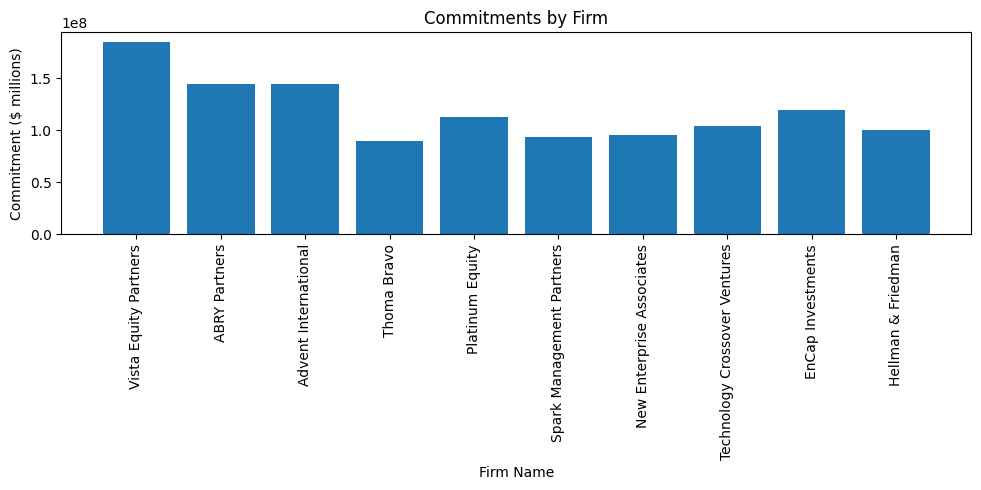

In [7]:
result = user_proxy.initiate_chat(
    recipient=pdf_processor,
    summary_method="reflection_with_llm",
    message=f"What data can you extract from the pdf under path {PDF_FILE_PATH} with the given schema {SCHEMA}"
)

user_proxy.initiate_chat(
    recipient=code_executor,
    summary_method="reflection_with_llm",
    message=f"""Write Python code to plot a chart of the firm and their commitments based on {result.chat_history[-2]['content']}.
            Save the chart to plot.png"""
)   